<a href="https://colab.research.google.com/github/saritadas007/datathon-2024-education-and-economic-growth/blob/main/DSSG_BERLIN__DATATHON_2024_World_bank_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSSG BERLIN DATATHON 2024 on "World Bank Open Data"
## The Effect of Education on Economic Growth
### Objective : Gender Disparities in Education and Labor Market Outcomes (Unemploymenent Reporting)
### Name : Sarita Das


In [9]:
# Import libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
# Read data:
df = pd.read_csv("dataset.csv")
df.head()
df['Indicator Name'].unique()

array(['Children out of school, primary, female',
       'Children out of school, primary, male',
       'Government expenditure on education, total (% of GDP)',
       'Government expenditure on education, total (% of government expenditure)',
       'Government expenditure per student, primary (% of GDP per capita)',
       'Government expenditure per student, secondary (% of GDP per capita)',
       'Government expenditure per student, tertiary (% of GDP per capita)',
       'Gross intake ratio in first grade of primary education, female (% of relevant age group)',
       'Gross intake ratio in first grade of primary education, male (% of relevant age group)',
       'Labor force, female (% of total labor force)',
       'Labor force, total',
       'Literacy rate, adult female (% of females ages 15 and above)',
       'Literacy rate, adult male (% of males ages 15 and above)',
       'Literacy rate, adult total (% of people ages 15 and above)',
       'Literacy rate, youth female (

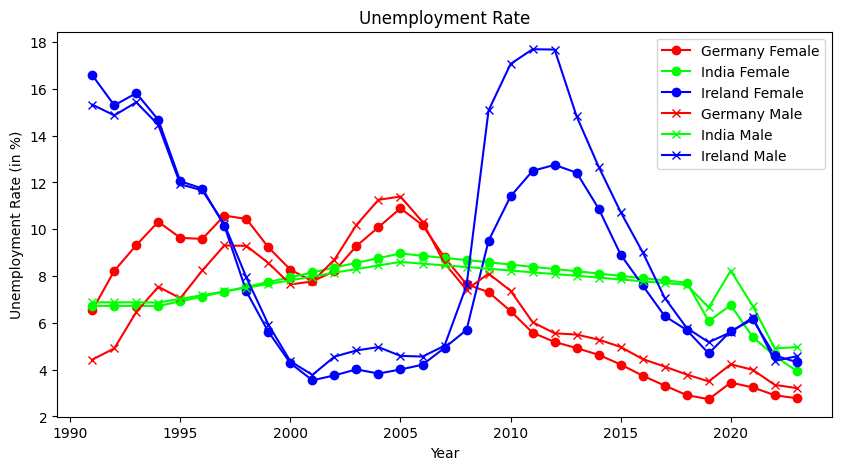

In [16]:
# Reshape the data into a suitable format for a line chart
df_pivot_female = df[(df["Indicator Name"] == "Unemployment, female (% of female labor force) (modeled ILO estimate)")\
             & (df["Country Name"].isin(["Ireland","Germany","India"]))]\
            .pivot(index="year", columns = "Country Name", values = "value")
df_pivot_male = df[(df["Indicator Name"] == "Unemployment, male (% of male labor force) (modeled ILO estimate)")\
             & (df["Country Name"].isin(["Ireland","Germany","India"]))]\
            .pivot(index="year", columns = "Country Name", values = "value")

# Create the line chart
colors = {
    'Ireland': 'blue',
    'Germany': 'red',
    'India': 'lime'
}
plt.figure(figsize=(10,5))
for country in df_pivot_female.columns:
    plt.plot(df_pivot_female.index, df_pivot_female[country], marker='o', color=colors[f'{country}'], label=f'{country} Female')

# Plot male unemployment rates
for country in df_pivot_male.columns:
    plt.plot(df_pivot_male.index, df_pivot_male[country], marker='x', color=colors[f'{country}'], label=f'{country} Male')

# plt.plot(df_pivot_female.index, df_pivot_female.values, marker='o', label=f'{df_pivot_female.columns} Female')
# plt.plot(df_pivot_male.index, df_pivot_male.values, marker='x', label=f'{df_pivot_male.columns} male')
plt.title("Unemployment Rate")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (in %)")
plt.legend( loc = "upper right")

# Show the plot
plt.show()

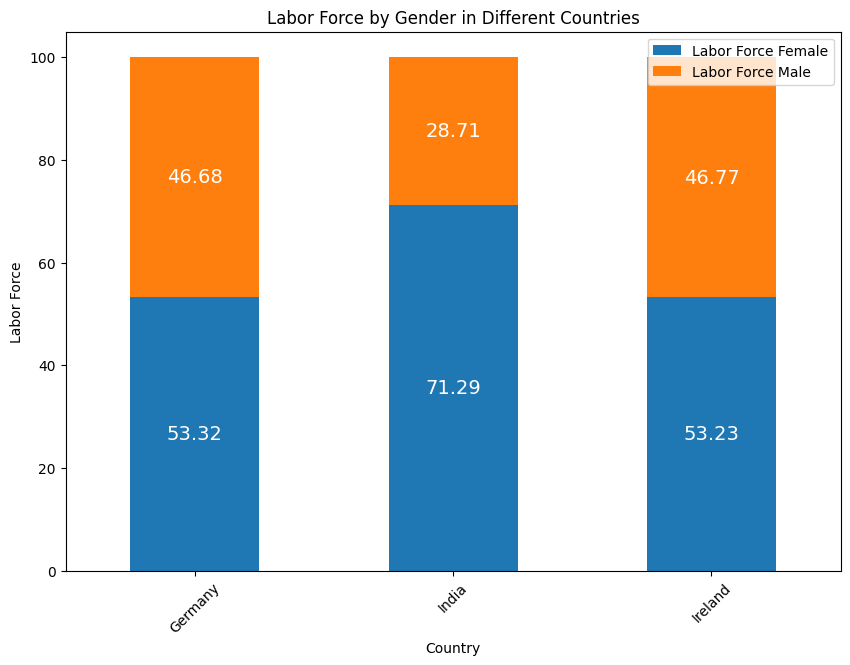

In [17]:
# Reshape the data into a suitable format for a line chart
df_labor = df[(df["Indicator Name"].isin(["Labor force, female (% of total labor force)", "Labor force, total"]))\
             & (df["Country Name"].isin(["Ireland","Germany","India"]))]\
           .pivot_table(index=["year", "Country Name", "Country Code"], columns="Indicator Name", values="value",aggfunc = "sum")\
           .reset_index()

# Get data for the year 2023
df_labor = df_labor[df_labor["year"]== 2023]

# Calculate the male labor force
df_labor["Labor force, male (% of total labor force)"] = 100 - df_labor["Labor force, female (% of total labor force)"]

# Set the index to 'Country' for easier plotting
df_labor.set_index("Country Name", inplace=True)

# Plotting the stacked bar chart
ax = df_labor[["Labor force, male (% of total labor force)", "Labor force, female (% of total labor force)"]].plot(kind="bar", stacked=True, figsize=(10, 7))

# Adding labels within the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center', fontsize=14, color='white')

# Adding labels and title
ax.set_xlabel("Country")
ax.set_ylabel("Labor Force")
ax.set_title("Labor Force by Gender in Different Countries")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.legend(["Labor Force Female", "Labor Force Male"])

# Show the plot
plt.show()

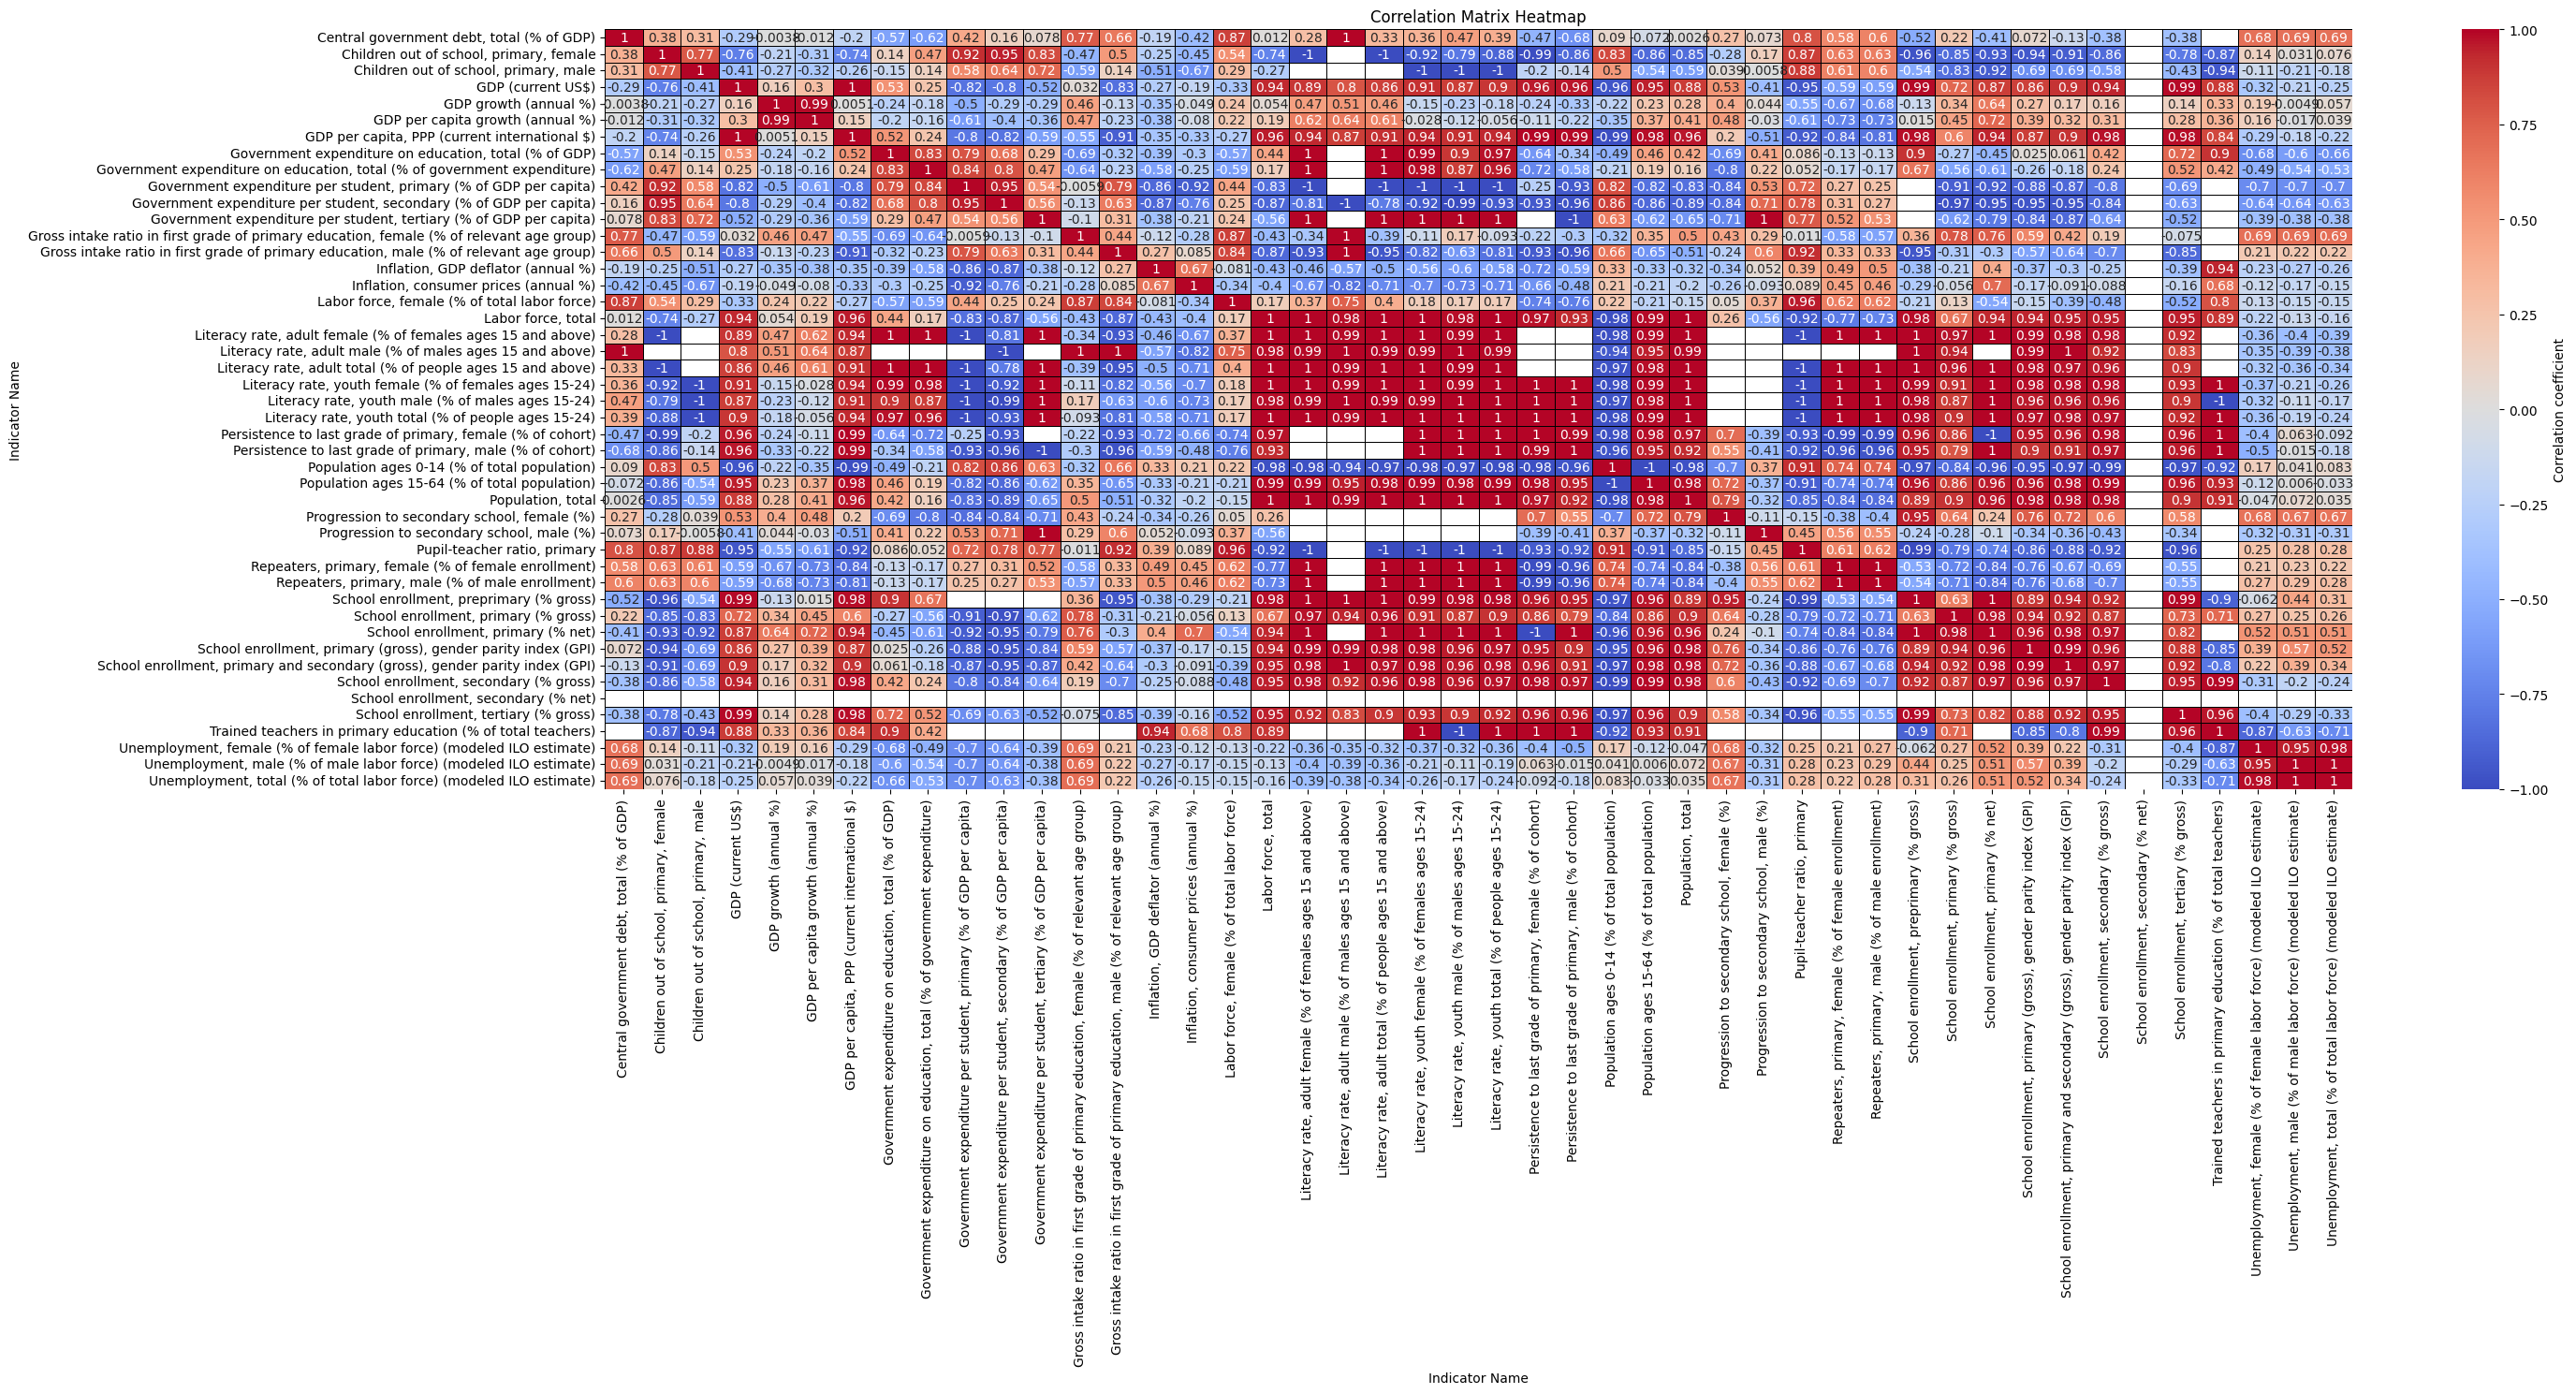

Top 10 features correlated with the target indicator:
Indicator Name
Unemployment, total (% of total labor force) (modeled ILO estimate)                         0.977457
Unemployment, male (% of male labor force) (modeled ILO estimate)                           0.952487
Trained teachers in primary education (% of total teachers)                                -0.867961
Government expenditure per student, primary (% of GDP per capita)                          -0.702388
Gross intake ratio in first grade of primary education, female (% of relevant age group)    0.686187
Central government debt, total (% of GDP)                                                   0.681624
Government expenditure on education, total (% of GDP)                                      -0.680318
Progression to secondary school, female (%)                                                 0.676468
Government expenditure per student, secondary (% of GDP per capita)                        -0.642082
School enrollment, pri

In [20]:
df_filtered=[]
# Obtain the correlation matrix
# correlation_matrix = df[(df['Country Code']=='IND') & (df["Indicator Name"].isin(["Literacy rate, adult female (% of females ages 15 and above)","Government expenditure per student, tertiary (% of GDP per capita)","Unemployment, female (% of female labor force) (modeled ILO estimate)"])) &  (~df['value'].isna())].pivot(index='year', columns='Indicator Name', values='value').corr()
df_filtered = df[(df['Country Code']=='IND') & (~df['value'].isna())]
df_pivot = df_filtered.pivot(index='year', columns='Indicator Name', values='value')
correlation_matrix = df_pivot.corr()
# Set a threshold for the absolute value of correlation coefficients
threshold = 0

# Filter the correlation matrix
filtered_corr_matrix = correlation_matrix.applymap(lambda x: x if abs(x) >= threshold else np.nan)
# Plot the heatmap using seaborn
plt.figure(figsize=(30, 15))
# sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0,
            # linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation coefficient'}, linewidths=.5, linecolor='black')
# Add title and adjust layout
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
# Show the plot
plt.show()
# Define the target indicator
target_indicator = "Unemployment, female (% of female labor force) (modeled ILO estimate)"

# Extract the correlation of all features with the target indicator
target_corr = filtered_corr_matrix[target_indicator].drop(target_indicator)  # Drop the target itself

# Get the top 10 features with the highest correlation to the target indicator
top_10_features = target_corr.abs().nlargest(10).index
print("Top 10 features correlated with the target indicator:")
print(target_corr.loc[top_10_features])
print(type(target_corr.loc[top_10_features]))

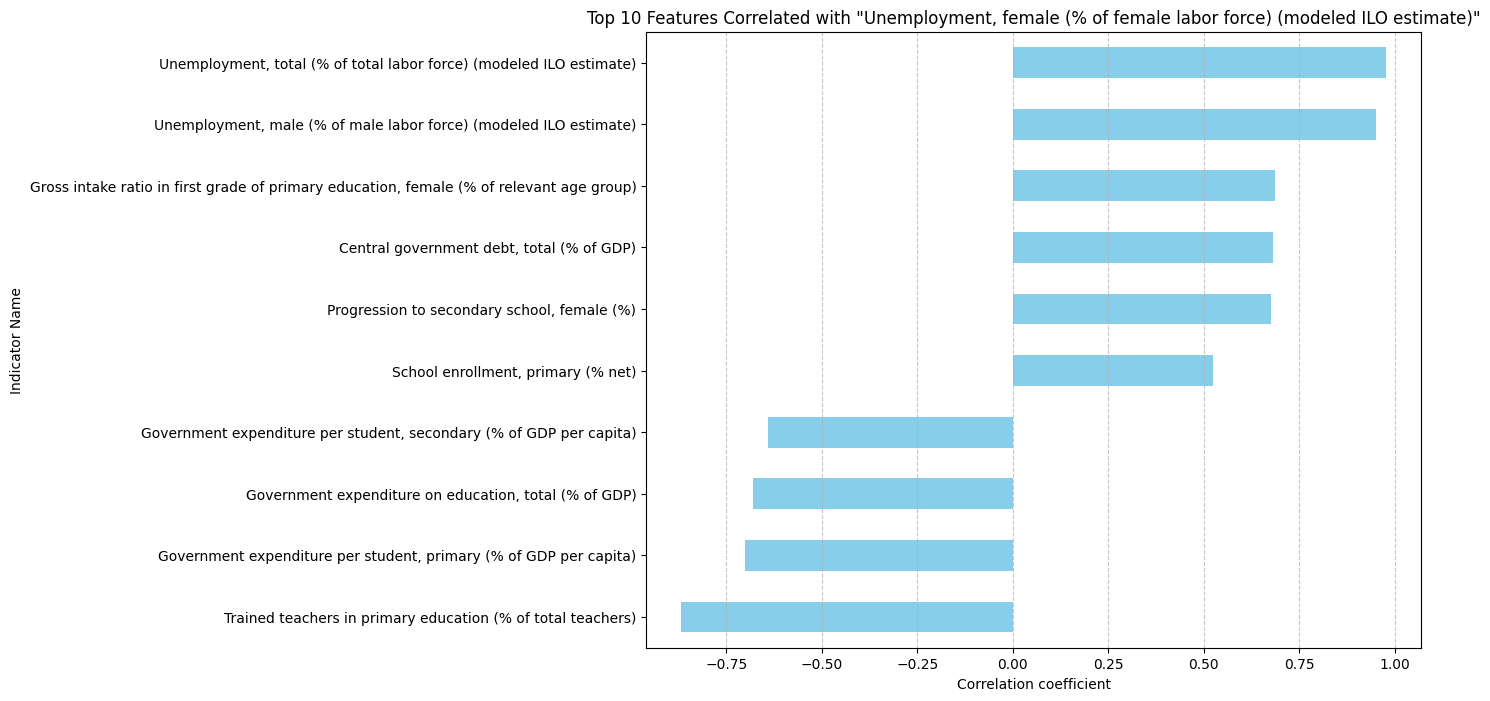

In [21]:
top_10_corr = target_corr.loc[top_10_features].sort_values()
plt.figure(figsize=(10, 8))
top_10_corr.plot(kind='barh', color='skyblue')
plt.xlabel('Correlation coefficient')
plt.ylabel('Indicator Name')
plt.title(f'Top 10 Features Correlated with "{target_indicator}"')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



Mean Squared Error: 0.09912578131428525
R-squared: 0.9454437592207283


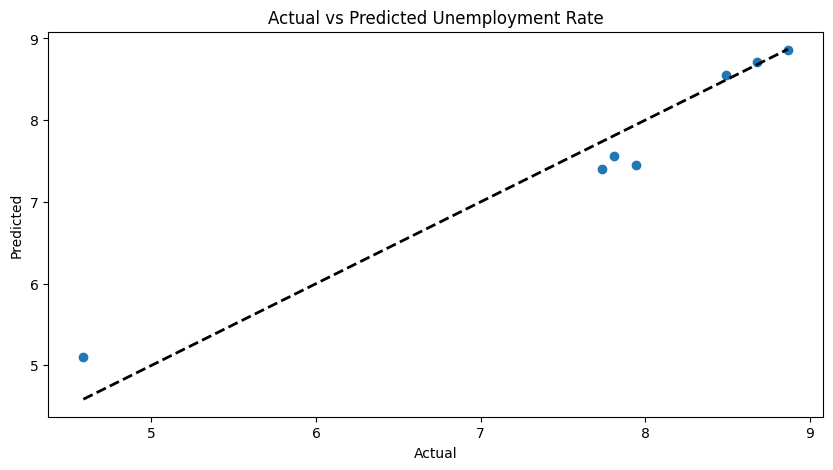

In [ ]:
from sklearn.impute import SimpleImputer
# Prepare the feature matrix (X) and the target vector (y)
X = df_pivot[top_10_features]
y = df_pivot[target_indicator]
# Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
# Remove rows in y where corresponding rows in X had missing values before imputation
missing_indices = y[y.isna()].index
y = y.dropna()
X_imputed = X_imputed.drop(index=missing_indices)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plotting actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Unemployment Rate')
plt.show()

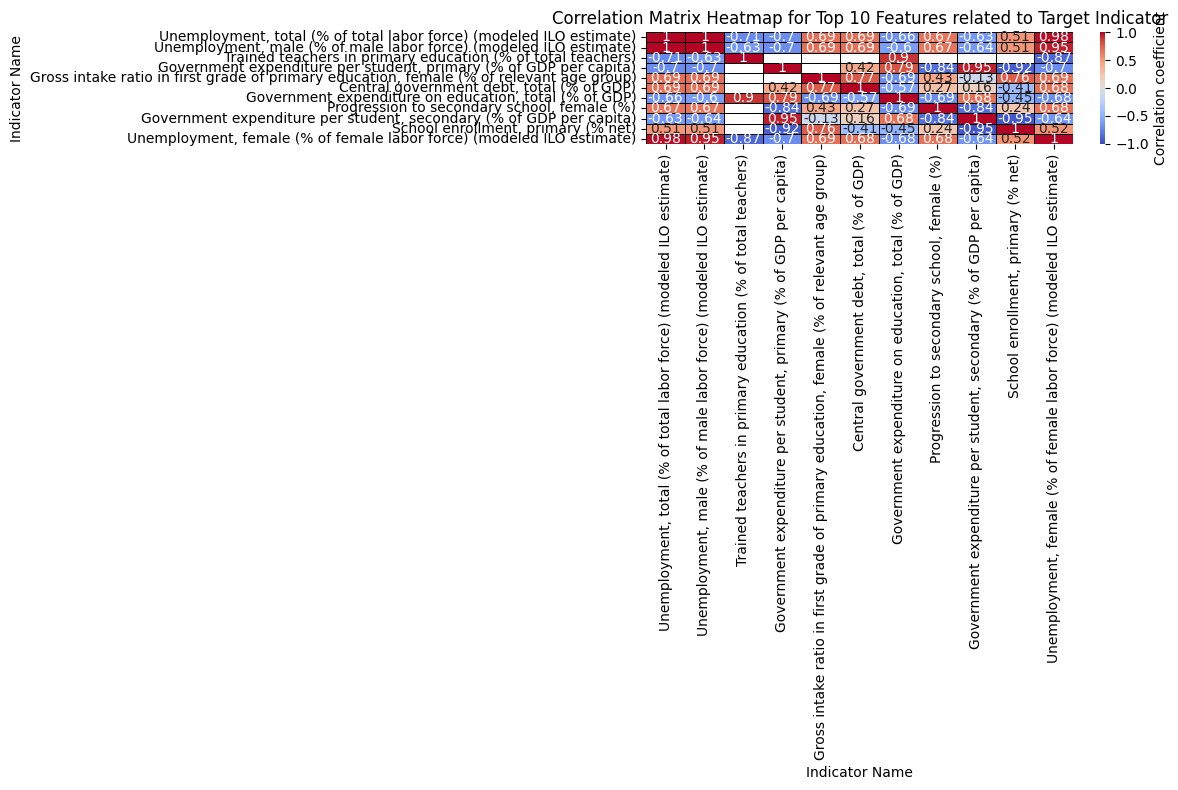

In [ ]:
# Filter the correlation matrix to include only the top 10 features and the target indicator
features_to_plot = list(top_10_features) + [target_indicator]
filtered_corr_matrix_2 = filtered_corr_matrix.loc[features_to_plot, features_to_plot]

# Plot the heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix_2, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation coefficient'}, linewidths=.5, linecolor='black')

# Add title and adjust layout
plt.title('Correlation Matrix Heatmap for Top 10 Features related to Target Indicator')
plt.tight_layout()

# Show the plot
plt.show()